# Introduction

This notebook aims to detect anomalies in financial markets using the Isolation Forest model.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV

# Data Cleaning

In [111]:
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS' )

# moving averages   
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['Cl1_moving_average'] = dataset['Cl1'].rolling(window=7).mean()
dataset['USGG2YR_moving_average'] = dataset['USGG2YR'].rolling(window=7).mean()
dataset['GT10_moving_average'] = dataset['GT10'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()



# Ratios
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Différences
dataset['VIX_diff'] = dataset['VIX'].diff()

dataset['Year'] = dataset['Data'].dt.year
dataset['Month'] = dataset['Data'].dt.month
dataset['Day'] = dataset['Data'].dt.day
dataset['DayOfWeek'] = dataset['Data'].dt.dayofweek
dataset['Is_weekend'] = dataset['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

#correlation
correlation_matrix = dataset.corr()


low_cor_cols=correlation_matrix['Y'][abs(correlation_matrix['Y'])<0.04].index

#cleaning data
dataset_cleaned=dataset.drop(columns=low_cor_cols)


if 'Data' in dataset_cleaned.columns:
    dataset_cleaned = dataset_cleaned.drop(columns=['Data'])


# Data Preperation

In [112]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

In [113]:
class_counts = Counter(y_train)
negatives = class_counts[0]  # Normal class
positives = class_counts[1]  # Anomaly class

# Calcul du scale_pos_weight
scale_pos_weight = negatives / positives
print(f"Scale Pos Weight: {scale_pos_weight}")


Scale Pos Weight: 3.649214659685864


In [114]:
# Model inisialization
model = XGBClassifier(
    n_estimators=131, 
    learning_rate=0.3, 
    random_state=43, 
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       177
           1       0.83      0.74      0.78        46

    accuracy                           0.91       223
   macro avg       0.88      0.85      0.86       223
weighted avg       0.91      0.91      0.91       223



# Investment Strategy Development

In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [115]:

dataset_cleaned['Anomaly'] = model.predict_proba(X)[:, 1] >= 0.15
dataset_cleaned['price'] = dataset_cleaned['VIX']

def define_strategy(row, entry_price=None):
    # Achat
    if row['Anomaly'] and row['VIX'] < row['VIX_moving_average'] and row['price'] < row['Cl1_moving_average']:
        return 'Buy'
    # Vente
    elif row['price'] > entry_price * 1.1 or row['price'] < entry_price * 0.95:
        return 'Sell'
    elif not row['Anomaly'] and row['VIX'] > row['VIX_moving_average']:
        return 'Sell'
    # Maintien
    elif row['Is_weekend'] == 1:
        return 'Hold'
    else:
        return 'Hold'



dataset_cleaned['Strategy'] = dataset_cleaned.apply(define_strategy, axis=1)

print(dataset_cleaned[['VIX', 'VIX_moving_average', 'Anomaly', 'Strategy']])


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [116]:
# Initialisation
initial_portfolio = 100000  # Capital initial
portfolio = initial_portfolio
position = 0
entry_price = None

portfolio_values = []  # Liste pour stocker les valeurs du portefeuille à chaque étape

# Simulation de la stratégie
for index, row in dataset_cleaned.iterrows():
    if row['Strategy'] == 'Buy' and position == 0:
        entry_price = row['price']  # Remplacez par la colonne correcte pour les prix
        position = portfolio / entry_price  # Acheter
    elif row['Strategy'] == 'Sell' and position > 0:
        portfolio = position * row['price']  # Vendre
        position = 0
    
    # Ajouter la valeur actuelle du portefeuille
    portfolio_values.append(portfolio)

# Ajouter la colonne Portfolio_Value
dataset_cleaned['Portfolio_Value'] = portfolio_values

print(dataset_cleaned['Portfolio_Value'].sum())

KeyError: 'Strategy'

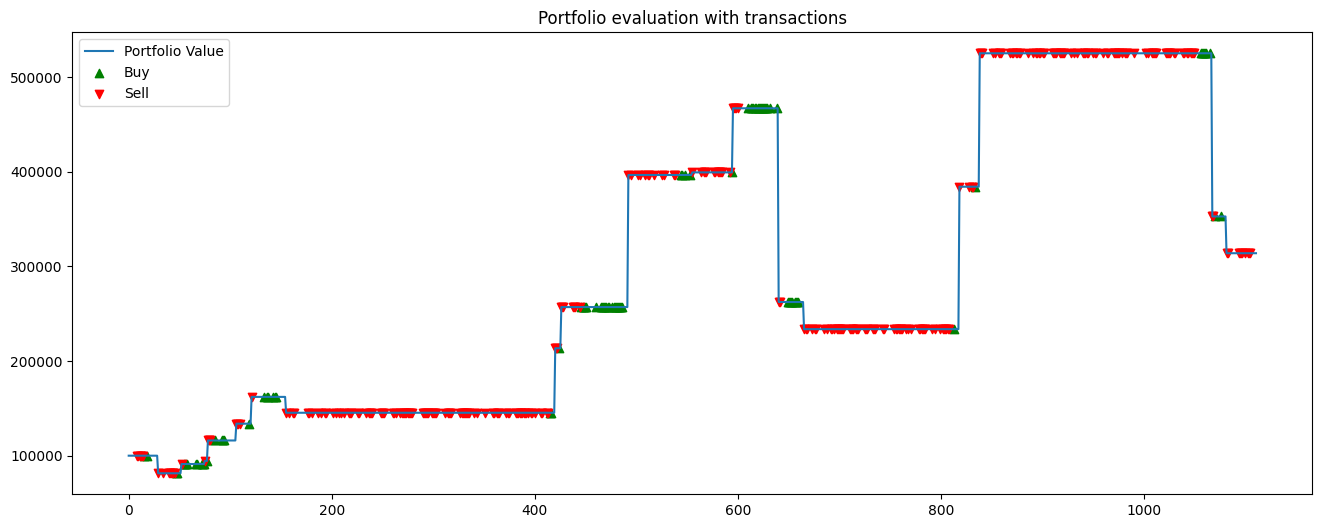

In [27]:
buy_points = dataset_cleaned[dataset_cleaned['Strategy'] == 'Buy'].index
sell_points = dataset_cleaned[dataset_cleaned['Strategy'] == 'Sell'].index

plt.figure(figsize=(16, 6))
plt.plot(dataset_cleaned['Portfolio_Value'], label="Portfolio Value")
plt.scatter(buy_points, dataset_cleaned.loc[buy_points, 'Portfolio_Value'], color='green', label='Buy', marker='^')
plt.scatter(sell_points, dataset_cleaned.loc[sell_points, 'Portfolio_Value'], color='red', label='Sell', marker='v')
plt.title("Portfolio evaluation with transactions")
plt.legend()
plt.show()
